In [ ]:
# Simple and straightforward treatment of the Kaggle Titanic dataset

In [1]:
#initial imports
import pandas as pd
import zipfile

In [2]:
# reading data directly from the zip file and saving it into a dataframe
zf=zipfile.ZipFile(r'C:\Users\Hov\Desktop\kaggle_titanic/titanic.zip')
df = pd.read_csv(zf.open('train.csv'))

In [3]:
#preliminary info about data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#seems that we have some missing values 
missing_values = len(df)-df.count()
missing_values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

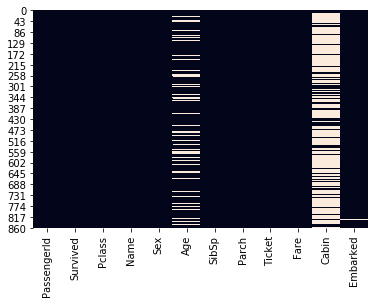

In [7]:
#let's visualize these missing values
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.isnull(),cbar=False)

In [8]:
#Cabin has a lot of missing values
#For simplicity we will drop this column
#Embarked has a few missing values. We will delete the rows containing no values
#Age however we will fill-in with the mean of known values
df['Age'].mean()

29.69911764705882

In [9]:
#mean imputation of age
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="mean")
df[['Age']] = imp.fit_transform(df[['Age']])

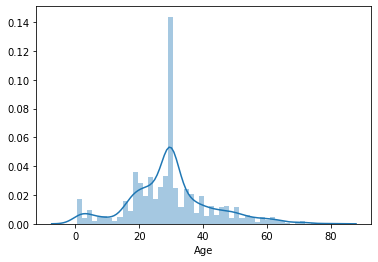

In [11]:
#let's see the distribution of age
sns.distplot(df['Age'], bins = 50)

In [12]:
#removing rows with no values for column Embarked
df.dropna(subset=['Embarked'], inplace=True)

In [13]:
#let's drop columns we will not need and also the Cabin column
df.drop(columns=['PassengerId', 'Name','Ticket','Cabin'],inplace=True)

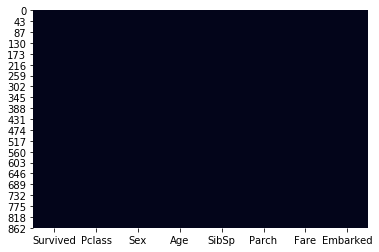

In [14]:
#let's see the dataframe again
sns.heatmap(df.isnull(),cbar=False)

In [ ]:
#we've kept only the columns we will be using for modeling

In [ ]:
#since the goal is to model the probability of survival, let's see some charts and statistics
#to get a feeling of how things are correlated

In [15]:
#distribution of genders onboard the Titanic
pd.crosstab(index=df["Survived"],columns=df["Sex"], margins=True)

Sex,female,male,All
Survived,,,
0,81,468,549
1,231,109,340
All,312,577,889


In [16]:
#at a first glance it seems that most passangers were males, but most of the females survived
#let's see that in percentages
pd.crosstab(index=df["Survived"],columns=df["Sex"], normalize='columns')

Sex,female,male
Survived,,
0,0.259615,0.811092
1,0.740385,0.188908


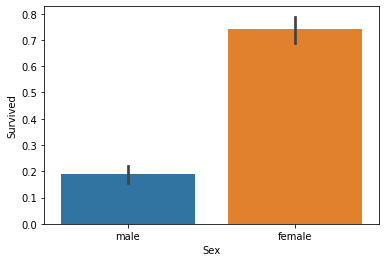

In [17]:
#74% of females survived as opposed to only 19% of males
#let's put that in a chart
sns.barplot(df['Sex'],df['Survived'])

In [ ]:
#as per standard practice used in ML, we will split the dataset into 
# target variable (output) and predictor variables (input)

In [21]:
#predictor variables 
# we will keep al variables except the Survived one
#we will also look at the shape of the resulting dataset (no. of rows and columns)
X= df.drop(['Survived'], axis = 1)
X.shape

(889, 7)

In [23]:
#target variable ( column vector)
y_train = df['Survived']
y_train.shape

(889,)

In [44]:
#we know that Sex variable has two levels (male / female), so let's see how many levels there are for 
#the other categorical variables
no_pclass = X.Pclass.nunique()
no_sibsp = X.SibSp.nunique()
no_parch = X.Parch.nunique()
no_embarked = X.Embarked.nunique()
print('\n',no_pclass,'\n',no_sibsp,'\n',no_parch,'\n',no_embarked)


 3 
 7 
 7 
 3


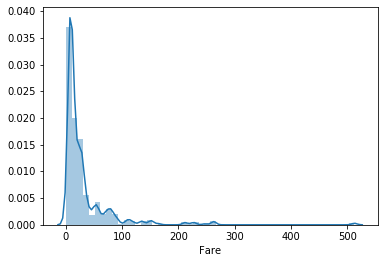

In [46]:
#now let's look at the continous variables Fare ( we already looked at Age)
sns.distplot(X.Fare)

In [49]:
#we will be using one hot encoding for categorical variables (Sex & Embarked) and standardization for continous variables
#(Age & Fare)
#the rest of the variables we keep them as they are
#since we will be using the same tranformations on the test dataset, we will be using make_column_transformer 
#to save some time and effort

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [50]:
column_trans = make_column_transformer((OneHotEncoder(), ['Sex','Embarked']),
                                       (StandardScaler(),['Age','Fare'])
                                       ,remainder="passthrough")

In [51]:
#apply the transformations to the X dataframe and save it as X_train
X_train= column_trans.fit_transform(X)

In [53]:
#now we will apply several models and evaluate the models using cross-validation
#import logistic regression, xgboosting and decision trees
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier as dtc
#import cross validation metric
from sklearn.model_selection import cross_val_score

In [61]:
#creat models
logreg = LogisticRegression(solver='lbfgs')
xgbmod=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
treemod = dtc(max_depth=2)

In [62]:
#evaluate models
print(
cross_val_score(logreg,X_train,y_train,cv=5,scoring='accuracy').mean(),
    '\n',
cross_val_score(xgbmod,X_train,y_train,cv=5,scoring='accuracy').mean(),
    '\n',
cross_val_score(treemod,X_train,y_train,cv=5,scoring='accuracy').mean()
)

0.786313718021964 
 0.8290484352186885 
 0.7727924839713071


In [ ]:
# looks like the boosting model has the better in-sample score, but it might just overfit
#let's use the created models to score the test cases

In [65]:
#importing the test cases into a dataframe and dropping the columns we would not be using
df_test = pd.read_csv(zf.open('test.csv'))
df_test.drop(columns=['PassengerId', 'Name','Ticket','Cabin'],inplace=True)

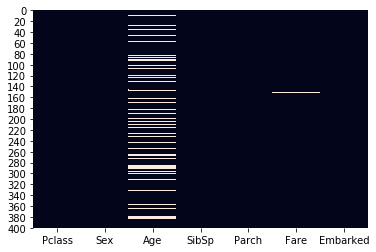

In [66]:
#check for any missing values
sns.heatmap(df_test.isnull(),cbar=False)

In [67]:
#drop the Fare missing observation
df_test.dropna(subset=['Fare'], inplace=True)

In [70]:
#imputation of the Age missing values
df_test[['Age']] = imp.fit_transform(df_test[['Age']])

In [72]:
#application of one hot encodings and standardizations
X_test= column_trans.fit_transform(df_test)

In [73]:
#train the logistic model, apply it to the new cases and export predictions in a csv file for submission
logmod = logreg.fit(X_train,y_train)
log_pred = logmod.predict(X_test)
pd.DataFrame(log_pred).to_csv(r"C:\Users\Hov\Desktop\kaggle_titanic\log_pred.csv")

In [74]:
#same for the boosting model
xgbmod.fit(X_train, y_train)
xgb_pred = xgbmod.predict(X_test)
pd.DataFrame(xgb_pred).to_csv(r"C:\Users\Hov\Desktop\kaggle_titanic\xgb_pred.csv")

In [75]:
#and the decision tree model
treemod = tree.fit(X_train,y_train)
tree_pred = treemod.predict(X_test)
pd.DataFrame(tree_pred).to_csv(r"C:\Users\Hov\Desktop\kaggle_titanic\tree_pred.csv")

In [ ]:
# Out of the 3 submissions, the tree model had the best score